# Infrared

In [1]:
##################################################
#
# Libraries
#


from metpy.plots    import colortables
from metpy.plots    import add_timestamp
from datetime       import datetime
from siphon.catalog import TDSCatalog
from datetime       import datetime

import numpy             as np
import os                as os
import pandas            as pd
import pathlib           as pathlib

import metpy
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature
import matplotlib.pyplot as plt


#
##################################################

In [2]:
##################################################
#
# Control Setup
#

# %load solutions/data_url.py

total_frames = 45*2

png_processing_directory = "./temp_files_sat_ir/"

gif_file_name = "./graphics_files/RealTime_SAT_IR_Loop.gif"

image_header_label = "GOES 16 Band 13 [10.3 µm Clean Longwarve IR Window]"

# Cell content replaced by load magic replacement.

# Create variables for URL generation

image_date = datetime.utcnow().date()
region = 'CONUS'
channel = 13

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string

data_url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/current/catalog.xml')

# Print out your URL and verify it works!

print(data_url)

#
##################################################

https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel13/current/catalog.xml


In [3]:
##################################################
#
# Pull Catalog
#

cat = TDSCatalog(data_url)

#
##################################################

In [4]:
##################################################
#
# Create File Inventories
#

file_names_to_retain = list()
file_names_to_use    = list()


for i in range(0,len(cat.datasets[0:total_frames])+1,1) : 
    filename = png_processing_directory + cat.datasets[i].name.replace(".nc",".png")
    file_names_to_retain.append(filename)
    file_names_to_use.append(filename)

        
files_on_hand = [png_processing_directory + s for s in os.listdir(png_processing_directory)]

file_names_to_retain.sort()
file_names_to_use.sort()


#
##################################################    

In [5]:
##################################################
#
# Clean PNG Directory
#

for filename in files_on_hand:
    if filename not in file_names_to_retain:
        print("Purging ", filename )
        os.remove( filename  )
    else:
        print("Keeping ", filename )
#
##################################################    

Purging  ./temp_files_sat_ir/.DS_Store


2022-01-31 00:06:17 UTC 2022-01-30 17:06:17 MST
range dat =  213.44844 301.2038
2022-01-31 00:01:17 UTC 2022-01-30 17:01:17 MST
range dat =  213.26408 301.5725
2022-01-30 23:56:17 UTC 2022-01-30 16:56:17 MST
range dat =  212.77246 302.0027
2022-01-30 23:51:17 UTC 2022-01-30 16:51:17 MST
range dat =  212.21938 302.30994
2022-01-30 23:46:17 UTC 2022-01-30 16:46:17 MST
range dat =  212.09647 302.7401
2022-01-30 23:41:17 UTC 2022-01-30 16:41:17 MST
range dat =  211.60484 303.0474
2022-01-30 23:36:17 UTC 2022-01-30 16:36:17 MST
range dat =  211.5434 303.23175
2022-01-30 23:31:17 UTC 2022-01-30 16:31:17 MST
range dat =  211.29758 303.66193
2022-01-30 23:26:17 UTC 2022-01-30 16:26:17 MST
range dat =  211.23611 303.96918
2022-01-30 23:21:17 UTC 2022-01-30 16:21:17 MST



KeyboardInterrupt



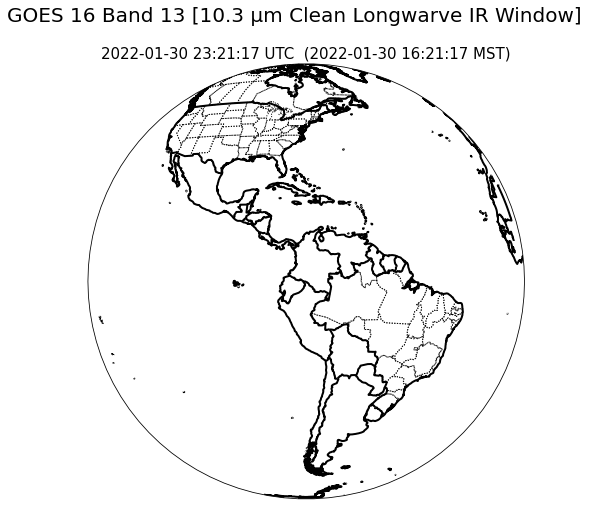

In [10]:
##################################################
#
# Create PNGs
#

for i in range(0,len(cat.datasets[0:total_frames])+1,1) : 

    dataset = cat.datasets[i]
    
    dataset_png_file_name = png_processing_directory + dataset.name.replace(".nc", ".png")
    
    if (not pathlib.Path(dataset_png_file_name).is_file() ):

        ds = dataset.remote_access(use_xarray=True)
        dat = ds.metpy.parse_cf('Sectorized_CMI')
        proj = dat.metpy.cartopy_crs
        x = dat['x']
        y = dat['y']


        tz='America/Denver'
        time_utc   = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
        valid_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d %H:%M:%S %Z")
        local_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").tz_convert(tz=tz).strftime("%Y-%m-%d %H:%M:%S %Z")

        file_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d_%H%M")


        print(valid_time,local_time)



        fig = plt.figure(figsize=(13, 8), facecolor = 'white')

        plt.suptitle(image_header_label,
                     fontsize = 20, 
                     color    = "black")
        ax = fig.add_subplot(1, 1, 1, projection=proj)
        ax.set_title(valid_time + "  (" + local_time+")",
                        fontsize=15, color="black")
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
        ax.add_feature(cfeature.STATES.with_scale('50m'),    linestyle=':', edgecolor='black')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'),   linewidth=2, edgecolor='black')
        

        print("range dat = ",np.nanmin(dat.values),np.nanmax(dat.values))
        im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')

        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 190, 310)
        im.set_cmap(wv_cmap)
        im.set_norm(wv_norm)

        
        plt.tight_layout()
        
        plt.savefig( dataset_png_file_name)
        plt.close()
    else:
        print("We already have this one!")
    

#
##################################################

In [ ]:
##################################################
#
# Convert PNGs into an Animated GIF
#

big_string = " ".join(file_names_to_use)

os.system("convert -delay 15 " + 
          big_string + 
          " " + 
          gif_file_name)

#
##################################################